In [27]:
import numpy as np
import legume
import chickpea
from chickpea.cma import CavityModeAnalysis
import matplotlib.pyplot as plt

%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Background

One of the most important parameters in a simulation using Legume is gmax. In a simulation, Legume performs a spatial fourier transform of the crystal. Gmax determines when the resulting fourier series is truncated. This has implications for the accuracy of the resulting simulation, as well as memory usage and runtime.

To illustrate some of the effects of gmax, let's initialize an H2 cavity as we did in the first notebook.

In [28]:
Nx, Ny = 16, 16
supercell = [Nx, Ny]

#we can modify this to suit our needs
thickness = 0.26/0.366
eps = 3.4**2
rad = 0.37
cavType = 'H'
n = 2

crystal = chickpea.PhotonicCrystalCavity(cavType, supercell, thickness, rad, eps, n)
phc = crystal.cavity()
base = crystal.get_base_crystal()

Now, we construct the Cavity mode analysis object.

In [30]:
defectMargins = np.array([0.25, 0.25])
cma = CavityModeAnalysis(phc, base, defectMargins, layer=0, gmax=2, base_gmax=3)
#using this method places some constraints on the parameters

[0.41165402]
Band gap lower bound: 0.276746.
Band gap upper bound: 0.420195.
Band gap center: 0.348471.
Gap-midgap ratio: 0.411654.
The top of the air band is at k= (3.141593, 1.813799).
The bottom of the dielectric band is at k= (4.188790, 0.000000).



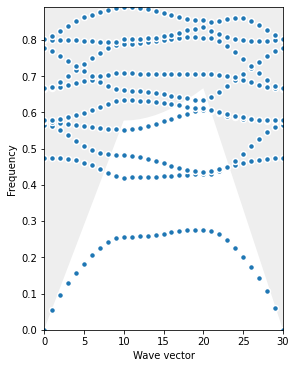

In [31]:
bandgaps, k_air, k_eps = cma.find_band_gaps(band_tol = 0.1, order=np.array([0]), trim_lc = True, lc_trim = 0.04, numeig=10)

gmg_ratio = np.array([(bandgap[1]-bandgap[0]) / bandgap[2] for bandgap in bandgaps])
legume.viz.bands(cma.base_gme, trim_light_cone = False, lc_trim = 0.04)
print(gmg_ratio)

print("Band gap lower bound: %f.\n"
      "Band gap upper bound: %f.\n"
      "Band gap center: %f.\n"
      "Gap-midgap ratio: %f.\n"
      "The top of the air band is at k= (%f, %f).\n"
      "The bottom of the dielectric band is at k= (%f, %f).\n" %  (bandgaps[0][0], bandgaps[0][1], bandgaps[0][2],
                                                                   gmg_ratio[0], k_air[0], k_air[1], k_eps[0], k_eps[1]))


Before we run any simulations, let's use Legume's viz.eps_ft method to look at how Legume "sees" our crystal for integer gmax values from 1 to 6. Notice the increase in fidelity as gmax increases.

KeyboardInterrupt: 

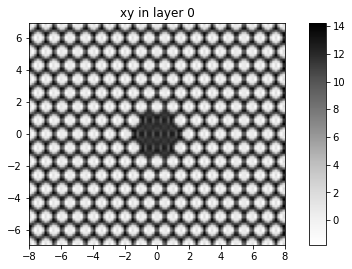

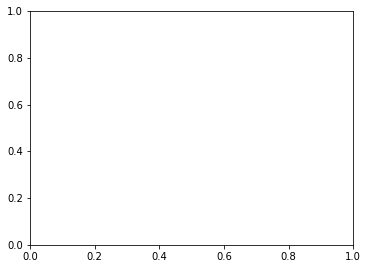

In [33]:
viz_gmaxes = range(1, 7)
for gmax in viz_gmaxes:

    gme = legume.GuidedModeExp(phc, gmax)
    legume.viz.eps_ft(gme, figsize=5)

In [34]:
options = {'verbose': True,
           'gmode_inds': [0],
           'gradients': 'approx',
           'eig_solver': 'eigsh', #for better memory usage and runtime
           'numeig': 1,
           'eig_sigma': 0.347, #we target this particular mode.
           'compute_im': False
}

To observe convergence with gmax, we require a large enough supercell.
Internally in Legume, gmax is scaled by $2\pi$ and truncated to an integer.
So, our input into gmax doesn't need to be an integer.

In [42]:
gmax_low = 1
gmax_high = 5
stepsize = 1
gmax_array = np.arange(gmax_low, gmax_high, stepsize)
kpoints = np.array([[k_air[0][0]], [k_air[1][0]]])

Now, we're ready to simulate over a range of gmax values.
Note the runtime and memory usage, as well as the resulting Q-factor value for each gmax.

0.7750s total time for real part of frequencies, of which
  0.1220s for guided modes computation using the gmode_compute='exact' method
  0.0980s for inverse matrix of Fourier-space permittivity
  0.0639s for matrix diagionalization using the 'eigsh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes
peak memory: 330.11 MiB, increment: 132.21 MiB
10.7468s total time for real part of frequencies, of which
  0.3420s for guided modes computation using the gmode_compute='exact' method
  1.4820s for inverse matrix of Fourier-space permittivity
  1.0235s for matrix diagionalization using the 'eigsh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes
peak memory: 2430.17 MiB, increment: 2227.46 MiB
63.3558s total time for real part of frequencies, of which
  0.6570s for guided modes computation using the gmode_compute='

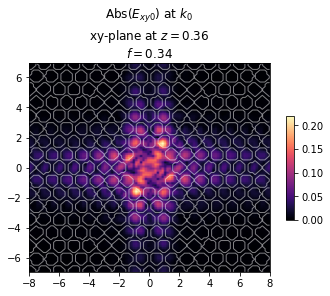

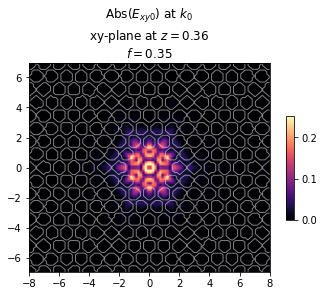

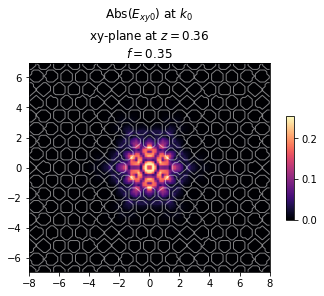

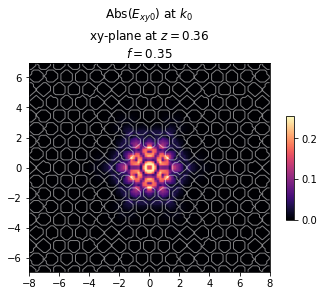

In [43]:
q_list = []
for gmax in gmax_array:
    gme = legume.GuidedModeExp(phc, gmax)
    %memit gme.run(kpoints=kpoints, **options)
    freq_im, _, _ = gme.compute_rad(0, [0])
    q_list.append(gme.freqs[0][0]/2/freq_im[0])
    legume.viz.field(gme,'E', 0, 0, z=thickness/2, component='xy', val='abs', N1=100, N2=100, norm=True)

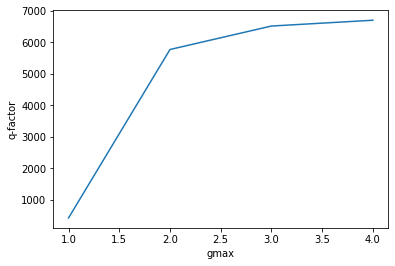

In [45]:
plt.plot(gmax_array, q_list)
plt.xlabel("gmax")
plt.ylabel("q-factor")
plt.show()


From the previous simulations, we can note a couple of things:
- Runtime and memory usage scale particularly badly with gmax - in fact, they're $O(\text{gmax}^4)$. Most of the runtime is from matrix inversion and diagonalization. The matrix on which these operations are performed scales $O(\text{gmax}^2)$ in linear dimension.
- The field becomes more localized as gmax increases. Under a certain threshold (for this simulation, when gmax was 1,) the mode wasn't localized at all, meaning that the resulting q-factor was effectively worthless. Above this threshold, the resulting modes are visually almost indistinguishable, and Q-factors can be estimated from a simulation from any Q-factor above the threshold, meaning that for optimization, we can simulate at a fairly low gmax.
- Q-factor increases monotonically with gmax, and empirically converges.